In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split

In [2]:
RAWDATA_PATH = r'./donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/'
DATA_PATH = r'./formatted_data'
DATASETS_PATH = r'./datasets_simple'

In [3]:
wav_count = 0
for _, _, files in os.walk(RAWDATA_PATH):
    for file in files:
        if file.lower().endswith('.wav'):
            wav_count += 1
print(f'Total number of WAV files: {wav_count}')

Total number of WAV files: 457


sr: min = 8000 Hz, max = 8000 Hz
len: min = 6.52 sec, max = 7.06 sec


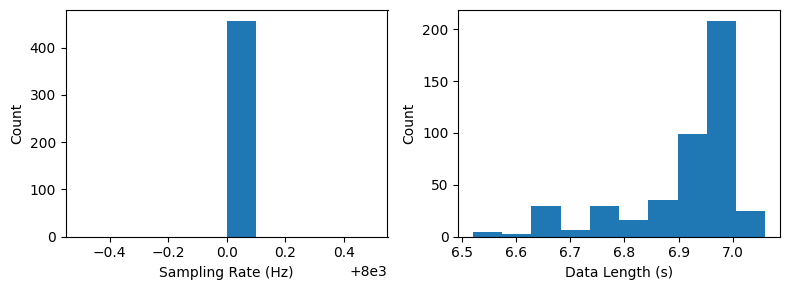

In [4]:
# データのsrや長さの確認
sr_list = []
len_list = []
for current, _, files in os.walk(RAWDATA_PATH):
    for file in files:
        if file.lower().endswith('.wav'):
            y, sr = librosa.load(os.path.join(current, file), sr=None)
            sr_list.append(sr)
            len_list.append(len(y))

sr_list = np.array(sr_list)
len_list = np.array(len_list)
len_list_sec = len_list / sr_list
print(f'sr: min = {np.min(sr_list)} Hz, max = {np.max(sr_list)} Hz')
print(f'len: min = {np.min(len_list_sec)} sec, max = {np.max(len_list_sec)} sec')

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.hist(sr_list)
plt.ylabel('Count')
plt.xlabel('Sampling Rate (Hz)')

# 2つ目のヒストグラム
plt.subplot(1, 2, 2)
plt.hist(len_list / sr_list)
plt.ylabel('Count')
plt.xlabel('Data Length (s)')

# グラフを表示
plt.tight_layout()
plt.show()

一旦、単純にCNNにぶっ込んでみる。  
必要な工程は以下。  
- データ整形 (長さ揃える、メルスペクトログラムにする)
- CNN設計

In [5]:
# データ整形
# 具体的には、音声の長さを揃えて(末尾を0埋め)、メルスペクトログラムにする
# torchvision.datasets.ImageFolder の形式に沿ってデータセットを構築

train_dir = os.path.join(DATASETS_PATH, 'train')
val_dir = os.path.join(DATASETS_PATH, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

target_size = np.max(len_list)
print(f'target size: {target_size}')

for class_name in os.listdir(RAWDATA_PATH):
    class_path = os.path.join(RAWDATA_PATH, class_name)
    if os.path.isdir(class_path):
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        
        wav_files = os.listdir(class_path)
        train_files, val_files = train_test_split(wav_files, test_size=0.2, random_state=42)

        for save_dir, files in {train_class_dir: train_files, val_class_dir: val_files}.items():
            for file in files:
                if file.lower().endswith('.wav'):
                    y, sr = librosa.load(os.path.join(class_path, file), sr=None)
                    original_size = len(y)
                    if original_size < target_size:
                        formatted_y = np.zeros(target_size, dtype=y.dtype)
                        formatted_y[:original_size] = y
                    else:
                        formatted_y = y
                    
                    mel_spectrogram = librosa.feature.melspectrogram(y=formatted_y, sr=sr)
                    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
                    mel_spectrogram = cv2.normalize(mel_spectrogram, None, 0, 255, cv2.NORM_MINMAX)
                    mel_spectrogram = mel_spectrogram.astype(np.uint8)
                    cv2.imwrite(os.path.join(save_dir, '.'.join(file.split('.')[:-1]) + '.png'), mel_spectrogram)

target size: 56480
